# Imports

In [73]:
from itertools import product
from typing import Sequence

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import FloatLogSlider, interact, FloatSlider
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, balanced_accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split, PredefinedSplit
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from wordcloud import WordCloud

# Helpers

## Função de plotagem do notebook 5a_arvores_de_decisao

In [2]:
def plot_data_clf(X, y, model=None, heatmap=False, margin=True, support=True, errors=False,
              legend=True, colors=['bo','rx','gd','ms','c^','yP'], reverse_colors=False, N=100, gap=1e-9):
    '''Plot 1-D or 2-D classification dataset and classifier decision regions'''
    assert len(X.shape) == 2 and len(y.shape) == 1
    classes = list(np.unique(y))
    if model is not None:
        assert set(classes) <= set(model.classes_)
        classes = list(model.classes_)
    assert len(classes) <= len(colors)
    cmap = 'bwr'
    if reverse_colors:
        colors = colors[1::-1] + colors[2:]
        cmap = 'bwr_r'
    dim = X.shape[1]
    assert 0 < dim <= 2
    if dim == 1:
        for i in range(len(classes)):
            plt.plot(X[y == classes[i]], np.zeros(np.sum(y == classes[i])), colors[i], label=classes[i])
        plt.gca().axes.get_yaxis().set_ticks([])
        plt.xlabel('x')
    else:
        for i in range(len(classes)):
            plt.plot(X[y == classes[i], 0], X[y == classes[i], 1], colors[i], label=classes[i])
        plt.xlabel('x1')
        plt.ylabel('x2')
    if legend:
        plt.legend()
    if model is None:
        return
    x1_min, x1_max = X[:,0].min()-gap, X[:,0].max()+gap
    if dim == 1:
        x2_min, x2_max = -1, 1
        N2 = 2
    else:
        x2_min, x2_max = X[:,1].min()-gap, X[:,1].max()+gap
        N2 = N
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, N), np.linspace(x2_min, x2_max, N2))
    if dim == 1:
        XX = np.c_[xx1.reshape(-1)]
    else:
        XX = np.c_[xx1.reshape(-1), xx2.reshape(-1)]
    if errors:
        err = model.predict(X) != y
        vert = X[err, 1] if dim == 2 else np.zeros(np.sum(err))
        plt.plot(X[err, 0], vert, 'ks', mfc='none', markersize=10)
    if len(classes) > 2:
        y_pred = model.predict(XX)
        y_pred = np.array([classes.index(a) for a in y_pred])
        y_pred = y_pred.reshape(xx1.shape)
        levels = np.arange(len(classes) + 1) - 0.5
        plt.contour(xx1, xx2, y_pred, levels, colors='k', linewidths=1)
        plt.contourf(xx1, xx2, y_pred, levels, colors=[c[0] for c in colors], alpha=0.25)
        return
    if hasattr(model, 'predict_proba'):
        p = model.predict_proba(XX)[:,1].reshape(xx1.shape)
        plt.contour(xx1, xx2, p, levels=[0.5], colors='k', linewidths=1)
        plt.contourf(xx1, xx2, p, levels=[-np.inf, 0.5, np.inf], colors=[c[0] for c in colors], alpha=0.25)
        if heatmap:
            plt.contourf(xx1, xx2, p, levels=100, cmap=cmap, vmin=-1, vmax=2)
    else:
        z = model.decision_function(XX).reshape(xx1.shape)
        plt.contour(xx1, xx2, z, levels=[0], colors='k', linewidths=1)
        plt.contourf(xx1, xx2, z, levels=[-np.inf, 0, np.inf], colors=[c[0] for c in colors], alpha=0.25)
        if margin:
            plt.contourf(xx1, xx2, z, levels=[-1, 0, 1], cmap=cmap, vmin=-3, vmax=3)
        if heatmap:
            a = np.max(np.abs(z))*2
            plt.contourf(xx1, xx2, z, 100, cmap=cmap, vmin=-a, vmax=a)
        if support and hasattr(model, 'support_'):
            S = X[model.support_]
            if dim == 1:
                S = np.c_[S, np.zeros(S.shape[0])]
            plt.plot(*S.T, 'go', mfc='none', ms=12)
    return

# Carregamento dos dados e EDA inicial

## Carregamento dos dados e análise básica inicial das colunas

In [4]:
df = pd.read_csv("../datasets/Tweets.csv")
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [5]:
df["sentiment"].value_counts()

sentiment
neutral     11118
positive     8582
negative     7781
Name: count, dtype: int64

In [6]:
df["target"] = df["sentiment"].replace({"neutral": 0, "positive": 0, "negative": 1})

/var/folders/hq/v6x2m9xs25x3zvdpyk8mp4y40000gn/T/ipykernel_9334/791106813.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["target"] = df["sentiment"].replace({"neutral": 0, "positive": 0, "negative": 1})


In [7]:
df.head()

,textID,text,selected_text,sentiment,target
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,1
2,088c60f138,my boss is bullying me...,bullying me,negative,1
3,9642c003ef,what interview! leave me alone,leave me alone,negative,1
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
 4   target         27481 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.0+ MB


In [9]:
df.isnull().sum()

textID           0
text             1
selected_text    1
sentiment        0
target           0
dtype: int64

In [10]:
print("Linhas duplicadas:", df.duplicated().sum())
df[df.duplicated()]

Linhas duplicadas: 0


,textID,text,selected_text,sentiment,target


In [11]:
df = df.dropna()

## Histograma do número de caracteres

In [12]:
df["char_count"] = df["text"].apply(len)

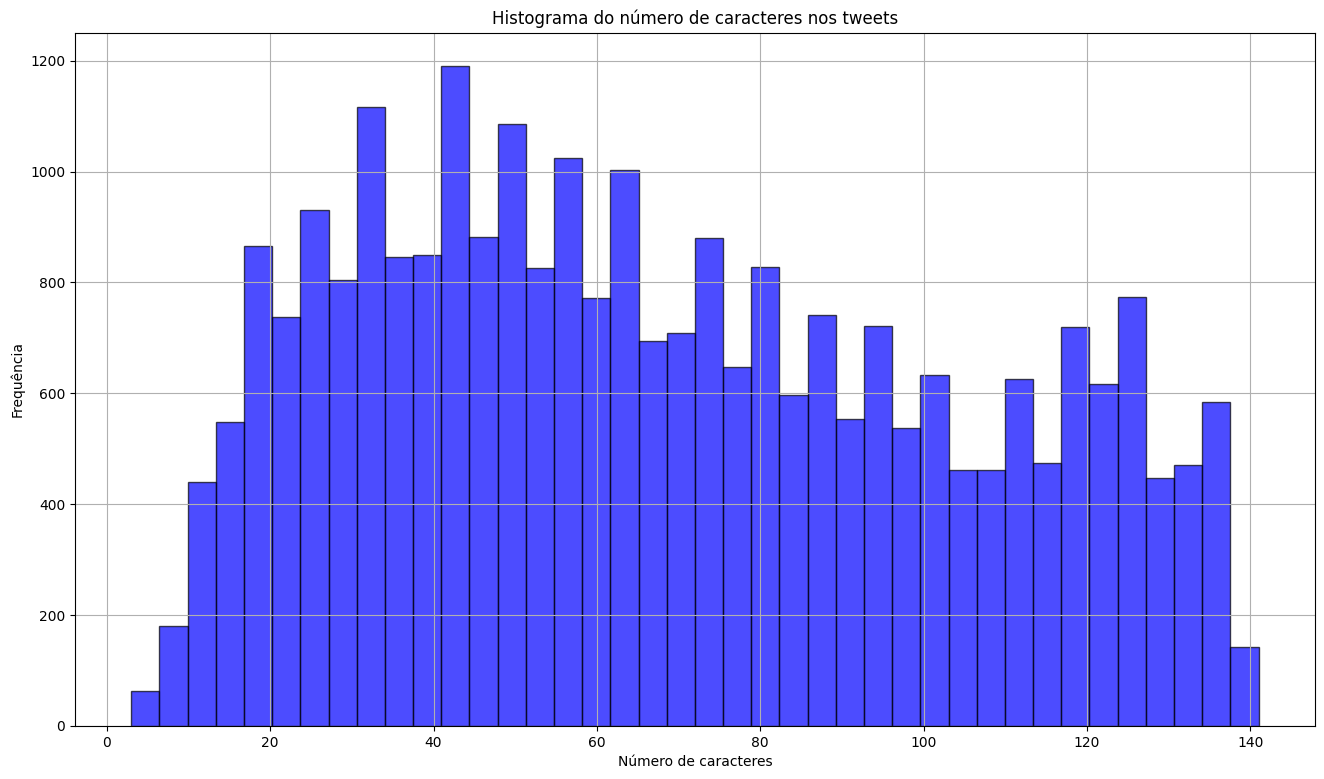

In [13]:
plt.figure(figsize=(16, 9))
df['char_count'].plot(kind='hist', bins=40, alpha=0.7, color='blue', edgecolor='black')
plt.title('Histograma do número de caracteres nos tweets')
plt.xlabel('Número de caracteres')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

## Histograma do número de palavras

In [14]:
df["word_count"] = df["text"].apply(lambda x: len(x.split()))

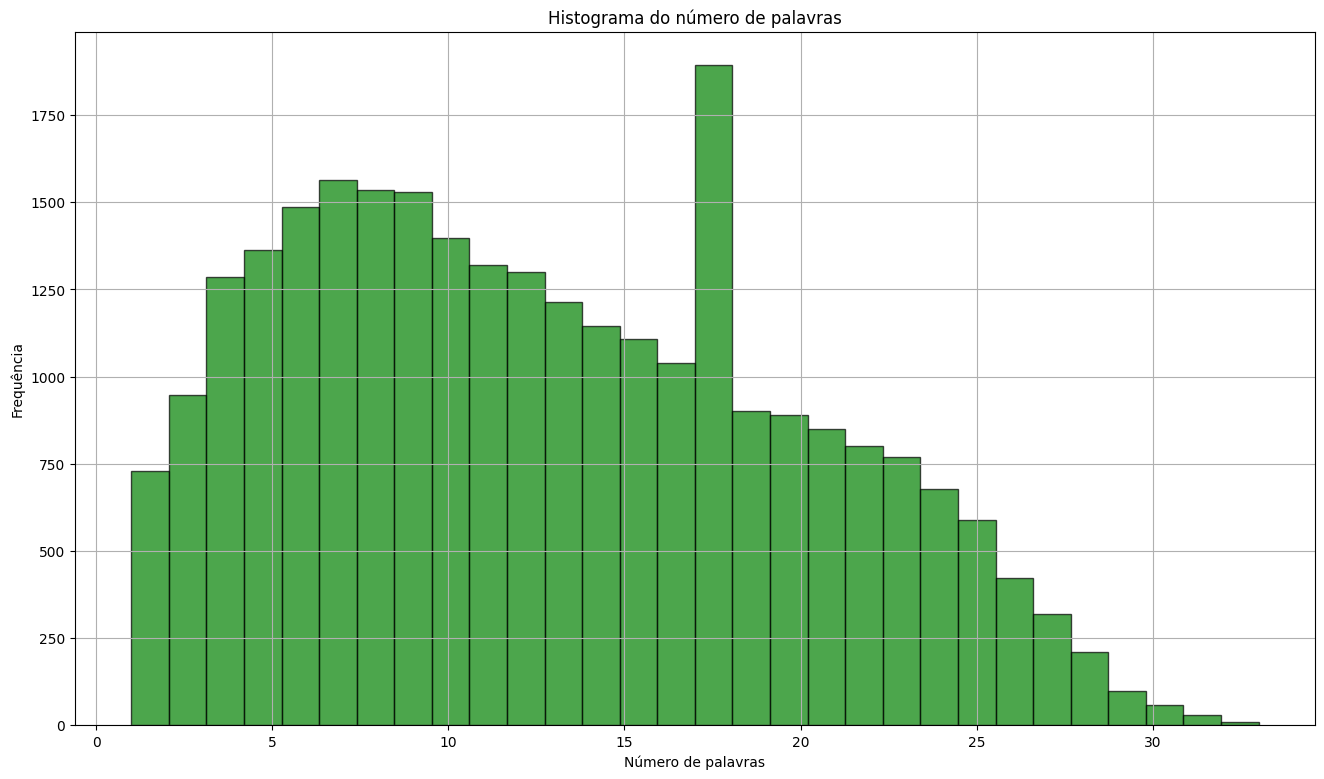

In [15]:
plt.figure(figsize=(16, 9))
df['word_count'].plot(kind='hist', bins=30, alpha=0.7, color='green', edgecolor='black')
plt.title('Histograma do número de palavras')
plt.xlabel('Número de palavras')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

## 5 maiores comentários

In [16]:
top_5_biggest_tweets = df.nlargest(5, "word_count")

In [17]:
for tweet in top_5_biggest_tweets["text"]:
    print(tweet)
    print()

AK, flop comes 2K6 I bet 15 get raised to 25 I call, turn is A, we check, river rag, then I check and he bets 15, I raise 15 he calls, 22

: Lol it went okay! As far as I can tell . But then I had to do a test today for geo and I was all zoned out and got like 65%

How I wish I get at least 2 days-off in a row. 1 day off is not enough to rest.  3 days on, 1 day off, 4 days on, 1 day off...Ugh!!!

My car is in the car hospital for the nxt 7 days  I gotta go pick up a loaner car b4 6! Bein without wheels 4 7day will set me back heavy!

First Happy Mothers Day  Second what is it that makes us think the way we do? Why do we feel the way we feel? I dont know but i wish i did



## 5 menores comentários

In [18]:
top_5_smallest_tweets = df.nsmallest(5, "word_count")

In [19]:
for tweet in top_5_smallest_tweets["text"]:
    print(tweet)
    print()

MAYDAY?!

Chilliin

 Absolutely

_nesmith

 Thx



## Wordcloud

In [20]:
def show_wordcloud(words: str) -> None:
    """Print the word cloud for a given text."""
    wordcloud = WordCloud(background_color="white").generate(words)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

### Todos os twwets

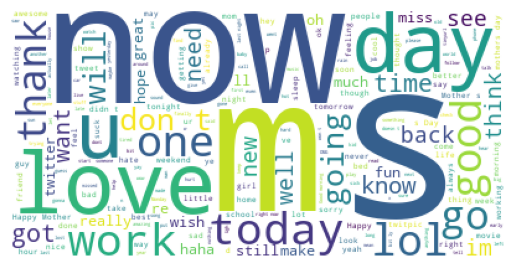

In [21]:
show_wordcloud(" ".join(tweet for tweet in df.text))

### Tweets negativos

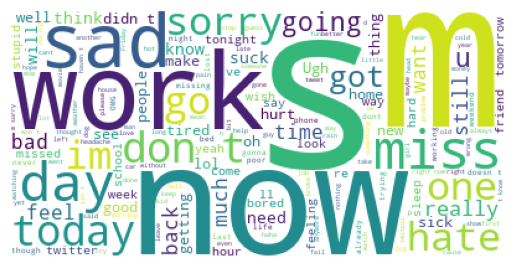

In [22]:
show_wordcloud(" ".join(tweet for tweet in df[df["sentiment"] == "negative"].text))

### Tweets neutros

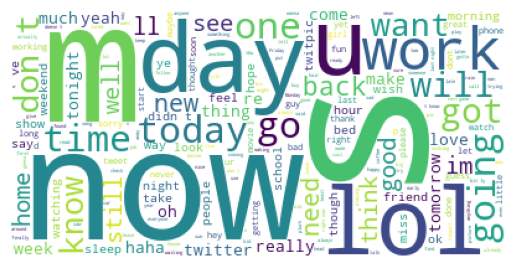

In [23]:
show_wordcloud(" ".join(tweet for tweet in df[df["sentiment"] == "neutral"].text))

### Tweets positivos

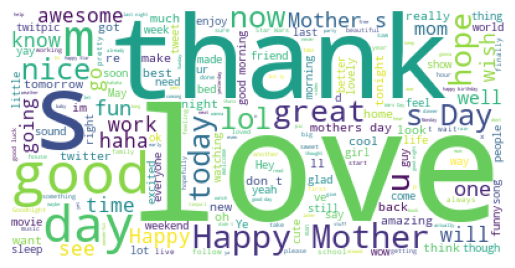

In [24]:
show_wordcloud(" ".join(tweet for tweet in df[df["sentiment"] == "positive"].text))

## Distribuição da variável alvo

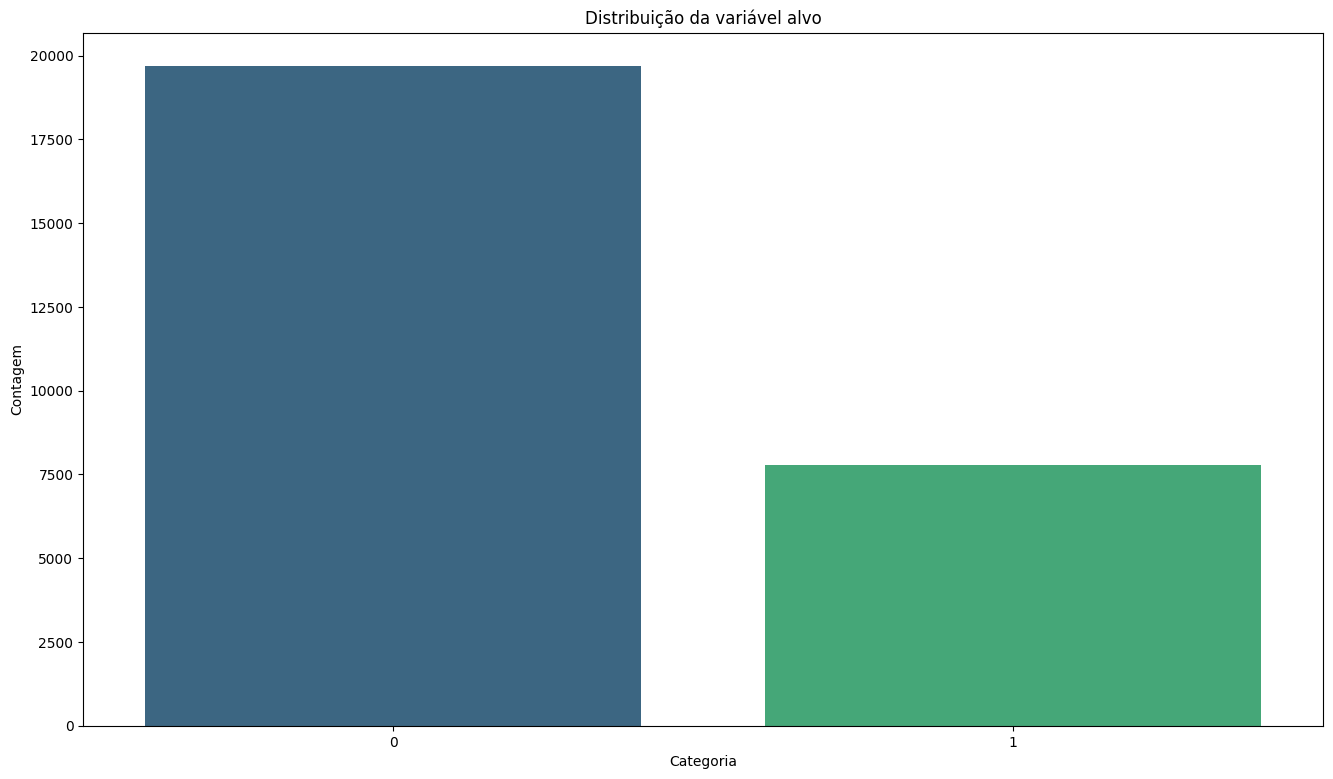

In [25]:
plt.figure(figsize=(16, 9))
sns.countplot(x="target", data=df, hue="target", legend=False, palette="viridis")
plt.title("Distribuição da variável alvo")
plt.xlabel("Categoria")
plt.ylabel("Contagem")
plt.show()

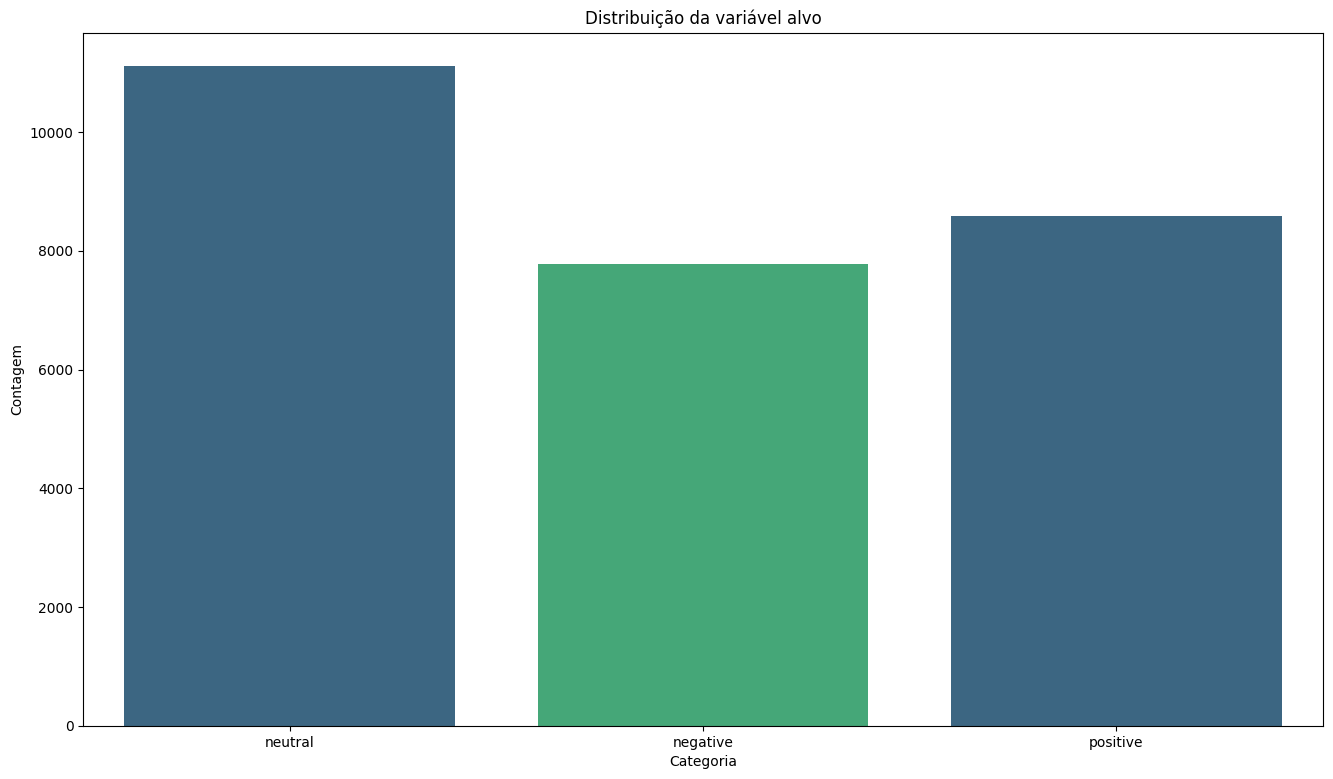

In [26]:
plt.figure(figsize=(16, 9))
sns.countplot(x="sentiment", data=df, hue="target", legend=False, palette="viridis")
plt.title("Distribuição da variável alvo")
plt.xlabel("Categoria")
plt.ylabel("Contagem")
plt.show()

# Limpeza e separação dos dados

## Limpeza

In [27]:
df = df.drop(columns=["textID", "selected_text", "sentiment", "char_count", "word_count"])

In [28]:
df.head()

,text,target
0,"I`d have responded, if I were going",0
1,Sooo SAD I will miss you here in San Diego!!!,1
2,my boss is bullying me...,1
3,what interview! leave me alone,1
4,"Sons of ****, why couldn`t they put them on t...",1


In [29]:
df.isnull().sum()

text      0
target    0
dtype: int64

In [30]:
print("Linhas duplicadas:", df.duplicated().sum())
df[df.duplicated()]

Linhas duplicadas: 0


,text,target


Sem necessidade de tratar dados faltantes (tratado anteriormente) e dados duplicados

## Split

In [31]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    df['text'],
    df['target'],
    test_size=0.2,
    stratify=df['target'],
    random_state=42
)

In [32]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=0.25,  # 25% of 80% is 20% of the total data
    stratify=y_train_val,
    random_state=42
)

No caso, utilizarei validação hold-out.

# Seleção de hiperparâmetros

In [33]:
preprocessing_pipeline = Pipeline([
    ("vectorizer", CountVectorizer())
])

In [34]:
balanced_accuracy = make_scorer(balanced_accuracy_score)

In [35]:
split_index = [-1] * len(X_train) + [0] * len(X_val)
X_train_val_combined = np.concatenate((X_train, X_val))
y_train_val_combined = np.concatenate((y_train, y_val))
ps = PredefinedSplit(test_fold=split_index)

## Regressão Logística

In [34]:
pipeline_lr = Pipeline([
    ("preprocessing", preprocessing_pipeline),
    ("classifier", LogisticRegression(max_iter=1000))
])
param_grid_lr = {
    "classifier__C": [1e-1, 1, 1e2],
}
grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, scoring=balanced_accuracy, n_jobs=8, verbose=2, cv=ps)

In [35]:
grid_search_lr.fit(X_train_val_combined, y_train_val_combined)

Fitting 1 folds for each of 3 candidates, totalling 3 fits


[CV] END ..................................classifier__C=0.1; total time=   0.2s
[CV] END ....................................classifier__C=1; total time=   0.3s
[CV] END ................................classifier__C=100.0; total time=   0.5s


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=Pipeline(steps=[('preprocessing',
                                        Pipeline(steps=[('vectorizer',
                                                         CountVectorizer())])),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=8, param_grid={'classifier__C': [0.1, 1, 100.0]},
             scoring=make_scorer(balanced_accuracy_score, response_method='predict'),
             verbose=2)

In [36]:
print("Melhores parâmetros (LR):", grid_search_lr.best_params_)
print("Melhor score (LR):", grid_search_lr.best_score_)

Melhores parâmetros (LR): {'classifier__C': 1}
Melhor score (LR): 0.7453316456356922


### Teste adicional mudando parâmetros no CountVectorizer

Como eu achei o desempenho relativamente baixo, decidi testar algumas mudanças no CountVectorizer para ver se o desempenho melhora.

In [37]:
pipeline_lr_cv = Pipeline([
    ("preprocessing", CountVectorizer()),
    ("classifier", LogisticRegression(max_iter=1000))
])
param_grid_lr_cv = {
    "preprocessing__max_df": (0.5, 0.75, 1.0),
    "preprocessing__ngram_range": [(1, 1), (1, 2)],
    "classifier__C": [1e-1, 1, 1e2],
}
grid_search_lr_cv = GridSearchCV(pipeline_lr_cv, param_grid_lr_cv, scoring=balanced_accuracy, n_jobs=8, verbose=2, cv=ps)

grid_search_lr_cv.fit(X_train_val_combined, y_train_val_combined)

Fitting 1 folds for each of 18 candidates, totalling 18 fits
[CV] END classifier__C=0.1, preprocessing__max_df=1.0, preprocessing__ngram_range=(1, 1); total time=   0.3s
[CV] END classifier__C=0.1, preprocessing__max_df=0.75, preprocessing__ngram_range=(1, 1); total time=   0.3s
[CV] END classifier__C=0.1, preprocessing__max_df=0.5, preprocessing__ngram_range=(1, 1); total time=   0.3s
[CV] END classifier__C=1, preprocessing__max_df=0.75, preprocessing__ngram_range=(1, 1); total time=   0.5s
[CV] END classifier__C=0.1, preprocessing__max_df=0.75, preprocessing__ngram_range=(1, 2); total time=   1.0s
[CV] END classifier__C=1, preprocessing__max_df=0.5, preprocessing__ngram_range=(1, 1); total time=   0.4s
[CV] END classifier__C=1, preprocessing__max_df=1.0, preprocessing__ngram_range=(1, 1); total time=   0.4s
[CV] END classifier__C=1, preprocessing__max_df=0.5, preprocessing__ngram_range=(1, 2); total time=   1.3s
[CV] END classifier__C=0.1, preprocessing__max_df=1.0, preprocessing__ng

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=Pipeline(steps=[('preprocessing', CountVectorizer()),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=8,
             param_grid={'classifier__C': [0.1, 1, 100.0],
                         'preprocessing__max_df': (0.5, 0.75, 1.0),
                         'preprocessing__ngram_range': [(1, 1), (1, 2)]},
             scoring=make_scorer(balanced_accuracy_score, response_method='predict'),
             verbose=2)

In [38]:
print("Melhores parâmetros (LR + Custom CV):", grid_search_lr_cv.best_params_)
print("Melhor score (LR + Custom CV):", grid_search_lr_cv.best_score_)

Melhores parâmetros (LR + Custom CV): {'classifier__C': 100.0, 'preprocessing__max_df': 0.5, 'preprocessing__ngram_range': (1, 2)}
Melhor score (LR + Custom CV): 0.749134185011679


Apesar de baixa, **houve** melhoria no score de validação

## SVM com kernel RBF

In [39]:
pipeline_svm = Pipeline([
    ("preprocessing", CountVectorizer()),
    ("classifier", SVC(kernel="rbf"))
])
param_grid_svm = {
    "classifier__C": 10.0**np.arange(-1, 3.01, 1),
    "classifier__gamma": 10.0**np.arange(-1, 3.01, 1)
}
grid_search_svm = GridSearchCV(pipeline_svm, param_grid_svm, scoring=balanced_accuracy, n_jobs=8, verbose=2, cv=ps)

In [40]:
grid_search_svm.fit(X_train_val_combined, y_train_val_combined)

Fitting 1 folds for each of 25 candidates, totalling 25 fits
[CV] END ...........classifier__C=0.1, classifier__gamma=0.1; total time=  41.2s
[CV] END ...........classifier__C=1.0, classifier__gamma=0.1; total time=  59.3s
[CV] END ...........classifier__C=0.1, classifier__gamma=1.0; total time= 1.1min
[CV] END .........classifier__C=0.1, classifier__gamma=100.0; total time= 1.3min


/Users/matheushent/Library/Mobile Documents/com~apple~CloudDocs/UFSC/EEL7514/.venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END ..........classifier__C=0.1, classifier__gamma=10.0; total time= 1.3min
[CV] END ........classifier__C=0.1, classifier__gamma=1000.0; total time= 1.3min
[CV] END ...........classifier__C=1.0, classifier__gamma=1.0; total time= 1.4min
[CV] END ..........classifier__C=1.0, classifier__gamma=10.0; total time= 1.6min
[CV] END .........classifier__C=1.0, classifier__gamma=100.0; total time= 1.5min
[CV] END ..........classifier__C=10.0, classifier__gamma=0.1; total time= 1.3min
[CV] END ........classifier__C=1.0, classifier__gamma=1000.0; total time= 1.5min
[CV] END .........classifier__C=100.0, classifier__gamma=0.1; total time= 1.3min
[CV] END ........classifier__C=10.0, classifier__gamma=100.0; total time= 2.1min
[CV] END ..........classifier__C=10.0, classifier__gamma=1.0; total time= 2.1min
[CV] END .........classifier__C=10.0, classifier__gamma=10.0; total time= 2.1min
[CV] END .......classifier__C=10.0, classifier__gamma=1000.0; total time= 2.4min
[CV] END .........classifier

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=Pipeline(steps=[('preprocessing', CountVectorizer()),
                                       ('classifier', SVC())]),
             n_jobs=8,
             param_grid={'classifier__C': array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'classifier__gamma': array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             scoring=make_scorer(balanced_accuracy_score, response_method='predict'),
             verbose=2)

In [41]:
print("Melhores parâmetros (SVM + kernel RBF):", grid_search_svm.best_params_)
print("Melhor score de cross-validation (SVM + kernel RBF):", grid_search_svm.best_score_)

Melhores parâmetros (SVM + kernel RBF): {'classifier__C': 10.0, 'classifier__gamma': 0.1}
Melhor score de cross-validation (SVM + kernel RBF): 0.7184010152284264


#### Print bônus dos meus processadores trabalhando bastante

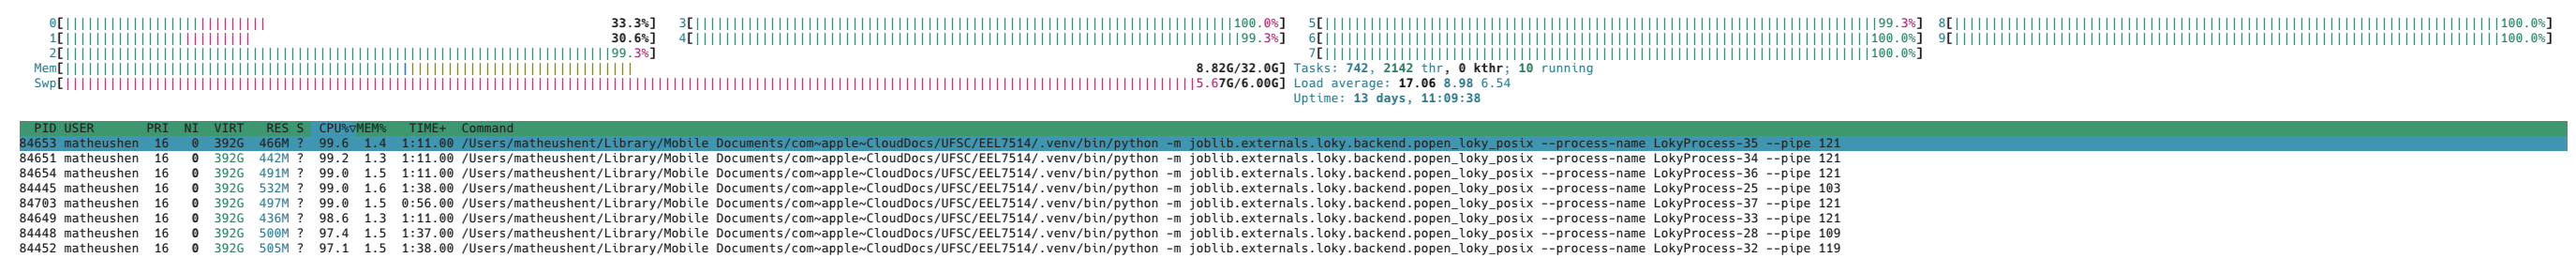

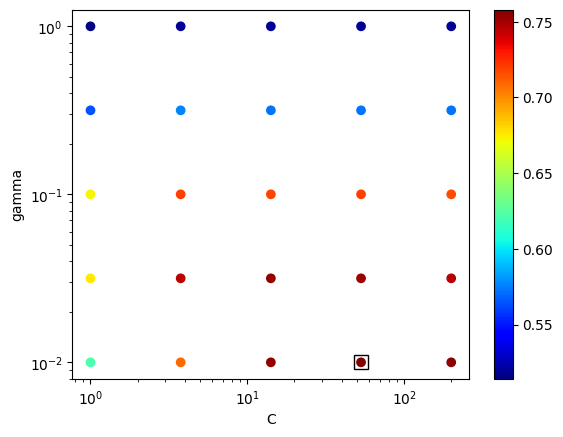

In [46]:
plt.scatter(grid_search_svm.cv_results_['param_classifier__C'], grid_search_svm.cv_results_['param_classifier__gamma'], c=grid_search_svm.cv_results_['mean_test_score'], cmap='jet');
plt.plot(grid_search_svm.best_params_['classifier__C'], grid_search_svm.best_params_['classifier__gamma'], 'ks', mfc='none', markersize=10)
plt.xlabel('C')
plt.ylabel('gamma')
plt.xscale('log')
plt.yscale('log')
plt.colorbar()
plt.show()

Busca mais fina em torno do ponto 1e1 x 1e-1

In [43]:
pipeline_svm = Pipeline([
    ("preprocessing", CountVectorizer()),
    ("classifier", SVC(kernel="rbf"))
])
param_grid_svm = {
    "classifier__C": np.geomspace(1, 200, 5),
    "classifier__gamma": np.geomspace(1e-2, 1, 5),
}
grid_search_svm = GridSearchCV(pipeline_svm, param_grid_svm, scoring=balanced_accuracy, n_jobs=8, verbose=2, cv=ps)

grid_search_svm.fit(X_train_val_combined, y_train_val_combined)

Fitting 1 folds for each of 25 candidates, totalling 25 fits
[CV] END ..........classifier__C=1.0, classifier__gamma=0.01; total time=  18.2s
[CV] END classifier__C=3.760603093086394, classifier__gamma=0.01; total time=  18.6s
[CV] END classifier__C=1.0, classifier__gamma=0.03162277660168379; total time=  24.9s
[CV] END classifier__C=3.760603093086394, classifier__gamma=0.03162277660168379; total time=  53.8s
[CV] END ...........classifier__C=1.0, classifier__gamma=0.1; total time=  55.1s
[CV] END classifier__C=1.0, classifier__gamma=0.31622776601683794; total time= 1.0min
[CV] END classifier__C=14.142135623730951, classifier__gamma=0.01; total time=  42.6s
[CV] END classifier__C=3.760603093086394, classifier__gamma=0.1; total time= 1.2min
[CV] END ...........classifier__C=1.0, classifier__gamma=1.0; total time= 1.2min
[CV] END classifier__C=3.760603093086394, classifier__gamma=0.31622776601683794; total time= 1.4min
[CV] END classifier__C=14.142135623730951, classifier__gamma=0.031622

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=Pipeline(steps=[('preprocessing', CountVectorizer()),
                                       ('classifier', SVC())]),
             n_jobs=8,
             param_grid={'classifier__C': array([  1.        ,   3.76060309,  14.14213562,  53.18295897,
       200.        ]),
                         'classifier__gamma': array([0.01      , 0.03162278, 0.1       , 0.31622777, 1.        ])},
             scoring=make_scorer(balanced_accuracy_score, response_method='predict'),
             verbose=2)

In [44]:
print("Melhores parâmetros (SVM + kernel RBF):", grid_search_svm.best_params_)
print("Melhor score de cross-validation (SVM + kernel RBF):", grid_search_svm.best_score_)

Melhores parâmetros (SVM + kernel RBF): {'classifier__C': 53.18295896944989, 'classifier__gamma': 0.01}
Melhor score de cross-validation (SVM + kernel RBF): 0.7579244581316144


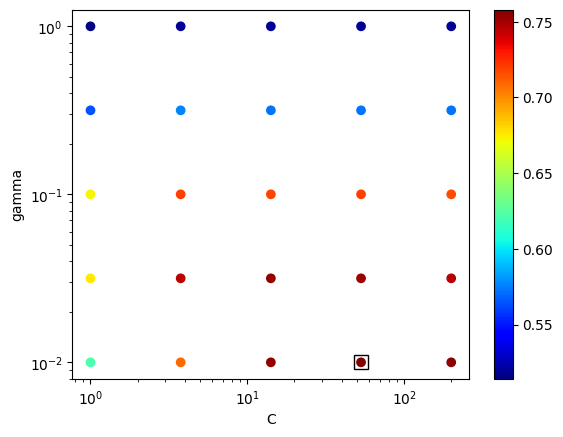

In [45]:
plt.scatter(grid_search_svm.cv_results_['param_classifier__C'], grid_search_svm.cv_results_['param_classifier__gamma'], c=grid_search_svm.cv_results_['mean_test_score'], cmap='jet');
plt.plot(grid_search_svm.best_params_['classifier__C'], grid_search_svm.best_params_['classifier__gamma'], 'ks', mfc='none', markersize=10)
plt.xlabel('C')
plt.ylabel('gamma')
plt.xscale('log')
plt.yscale('log')
plt.colorbar()
plt.show()

Outra busca mais fina

In [50]:
pipeline_svm = Pipeline([
    ("preprocessing", CountVectorizer()),
    ("classifier", SVC(kernel="rbf"))
])
param_grid_svm = {
    "classifier__C": np.geomspace(30, 50, 5),
    "classifier__gamma": np.geomspace(1e-3, 1e-1, 5),
}
grid_search_svm = GridSearchCV(pipeline_svm, param_grid_svm, scoring=balanced_accuracy, n_jobs=5, verbose=2, cv=ps)

grid_search_svm.fit(X_train_val_combined, y_train_val_combined)

Fitting 1 folds for each of 25 candidates, totalling 25 fits
[CV] END ........classifier__C=30.0, classifier__gamma=0.001; total time=  16.3s
[CV] END classifier__C=30.0, classifier__gamma=0.0031622776601683794; total time=  26.4s
[CV] END classifier__C=34.08658099402497, classifier__gamma=0.001; total time=  16.4s
[CV] END classifier__C=34.08658099402497, classifier__gamma=0.0031622776601683794; total time=  28.5s
[CV] END .........classifier__C=30.0, classifier__gamma=0.01; total time=  55.5s
[CV] END ..........classifier__C=30.0, classifier__gamma=0.1; total time= 1.2min
[CV] END classifier__C=30.0, classifier__gamma=0.03162277660168379; total time= 1.2min
[CV] END classifier__C=34.08658099402497, classifier__gamma=0.01; total time=  57.0s
[CV] END classifier__C=38.729833462074176, classifier__gamma=0.001; total time=  17.2s
[CV] END classifier__C=38.729833462074176, classifier__gamma=0.0031622776601683794; total time=  29.9s
[CV] END classifier__C=34.08658099402497, classifier__gam

/Users/matheushent/Library/Mobile Documents/com~apple~CloudDocs/UFSC/EEL7514/.venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END classifier__C=44.00558683966967, classifier__gamma=0.0031622776601683794; total time=  30.4s
[CV] END classifier__C=38.729833462074176, classifier__gamma=0.03162277660168379; total time= 1.2min
[CV] END classifier__C=38.729833462074176, classifier__gamma=0.1; total time= 1.2min
[CV] END ........classifier__C=50.0, classifier__gamma=0.001; total time=  17.3s
[CV] END classifier__C=44.00558683966967, classifier__gamma=0.01; total time= 1.0min
[CV] END classifier__C=50.0, classifier__gamma=0.0031622776601683794; total time=  35.5s
[CV] END classifier__C=44.00558683966967, classifier__gamma=0.03162277660168379; total time= 1.2min
[CV] END classifier__C=44.00558683966967, classifier__gamma=0.1; total time= 1.2min
[CV] END .........classifier__C=50.0, classifier__gamma=0.01; total time= 1.1min
[CV] END classifier__C=50.0, classifier__gamma=0.03162277660168379; total time= 1.1min
[CV] END ..........classifier__C=50.0, classifier__gamma=0.1; total time= 1.1min


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=Pipeline(steps=[('preprocessing', CountVectorizer()),
                                       ('classifier', SVC())]),
             n_jobs=5,
             param_grid={'classifier__C': array([30.        , 34.08658099, 38.72983346, 44.00558684, 50.        ]),
                         'classifier__gamma': array([0.001     , 0.00316228, 0.01      , 0.03162278, 0.1       ])},
             scoring=make_scorer(balanced_accuracy_score, response_method='predict'),
             verbose=2)

In [51]:
print("Melhores parâmetros (SVM + kernel RBF):", grid_search_svm.best_params_)
print("Melhor score (SVM + kernel RBF):", grid_search_svm.best_score_)

Melhores parâmetros (SVM + kernel RBF): {'classifier__C': 38.729833462074176, 'classifier__gamma': 0.01}
Melhor score de cross-validation (SVM + kernel RBF): 0.7591014967442224


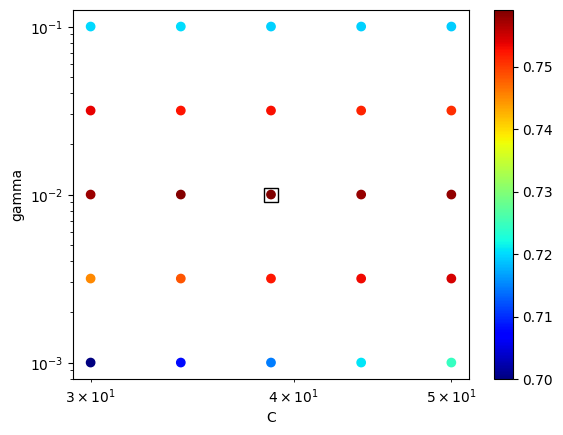

In [52]:
plt.scatter(grid_search_svm.cv_results_['param_classifier__C'], grid_search_svm.cv_results_['param_classifier__gamma'], c=grid_search_svm.cv_results_['mean_test_score'], cmap='jet');
plt.plot(grid_search_svm.best_params_['classifier__C'], grid_search_svm.best_params_['classifier__gamma'], 'ks', mfc='none', markersize=10)
plt.xlabel('C')
plt.ylabel('gamma')
plt.xscale('log')
plt.yscale('log')
plt.colorbar()
plt.show()

Com este último resultado, dou-me por satisfeito nesse modelo.

## Árvore de decisão

Para essa etapa, eu usei o código abaixo e fui treinando 3 a 3, ou seja, treinei um total de $n = \binom{6}{3}$ vezes, $\rightarrow n = 20$.

In [71]:
pipeline_dt = Pipeline([
    ("preprocessing", CountVectorizer()),
    ("classifier", DecisionTreeClassifier()),
])
param_grid_dt = {
    "classifier__max_depth": list(range(1, 21)),
    "classifier__min_samples_split": list(range(2, 6)),
    "classifier__min_samples_leaf": list(range(2, 21)),
    "classifier__max_leaf_nodes": list(range(2, 51)),
    "classifier__min_impurity_decrease": np.geomspace(1e-4, 1e-2, 20),
    "classifier__ccp_alpha": np.geomspace(1e-4, 1.5e-2, 20),
}
grid_search_dt = GridSearchCV(pipeline_dt, param_grid_dt, scoring=balanced_accuracy, n_jobs=6, verbose=2, cv=ps)

In [72]:
grid_search_dt.fit(X_train_val_combined, y_train_val_combined)

Fitting 1 folds for each of 1600 candidates, totalling 1600 fits
[CV] END classifier__ccp_alpha=0.0001, classifier__max_depth=1, classifier__min_samples_split=3; total time=   0.2s
[CV] END classifier__ccp_alpha=0.0001, classifier__max_depth=1, classifier__min_samples_split=2; total time=   0.2s
[CV] END classifier__ccp_alpha=0.0001, classifier__max_depth=1, classifier__min_samples_split=4; total time=   0.2s
[CV] END classifier__ccp_alpha=0.0001, classifier__max_depth=1, classifier__min_samples_split=5; total time=   0.2s
[CV] END classifier__ccp_alpha=0.0001, classifier__max_depth=2, classifier__min_samples_split=2; total time=   0.2s
[CV] END classifier__ccp_alpha=0.0001, classifier__max_depth=2, classifier__min_samples_split=3; total time=   0.2s
[CV] END classifier__ccp_alpha=0.0001, classifier__max_depth=2, classifier__min_samples_split=5; total time=   0.2s
[CV] END classifier__ccp_alpha=0.0001, classifier__max_depth=2, classifier__min_samples_split=4; total time=   0.2s
[CV] EN

KeyboardInterrupt: 

In [69]:
print("Melhores parâmetros (Decision Tree):", grid_search_dt.best_params_)
print("Melhor score (Decision Tree):", grid_search_dt.best_score_)

Melhores parâmetros (Decision Tree): {'classifier__ccp_alpha': 0.00048661636851873093, 'classifier__max_depth': 20, 'classifier__min_samples_split': 2}
Melhor score (Decision Tree): 0.6564795845131993


## Random Forest

In [80]:
pipeline_rf = Pipeline([
    ("preprocessing", CountVectorizer()),
    ("classifier", RandomForestClassifier()),
])
param_grid_rf = {
    "classifier__n_estimators": 10**np.arange(1, 5),
    "classifier__min_samples_split": list(range(2, 6)),
    "classifier__min_samples_leaf": list(range(2, 21)),
    "classifier__max_leaf_nodes": list(range(2, 51)),
    "classifier__min_impurity_decrease": np.geomspace(1e-4, 1e-2, 20),
    "classifier__ccp_alpha": np.geomspace(1e-4, 1.5e-2, 20),
}
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, scoring=balanced_accuracy, n_jobs=6, verbose=2, cv=ps)

In [81]:
grid_search_rf.fit(X_train_val_combined, y_train_val_combined)

Fitting 1 folds for each of 5958400 candidates, totalling 5958400 fits


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x106673310>>
Traceback (most recent call last):
  File "/Users/matheushent/Library/Mobile Documents/com~apple~CloudDocs/UFSC/EEL7514/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


[CV] END classifier__ccp_alpha=0.0001, classifier__max_leaf_nodes=2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=2, classifier__min_samples_split=3, classifier__n_estimators=10; total time=   0.2s
[CV] END classifier__ccp_alpha=0.0001, classifier__max_leaf_nodes=2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=2, classifier__min_samples_split=2, classifier__n_estimators=10; total time=   0.2s
[CV] END classifier__ccp_alpha=0.0001, classifier__max_leaf_nodes=2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=2, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.3s
[CV] END classifier__ccp_alpha=0.0001, classifier__max_leaf_nodes=2, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=2, classifier__min_samples_split=3, classifier__n_estimators=100; total time=   0.3s
[CV] END classifier__ccp_alpha=0.0001, classifier__max_leaf_nodes=2, classifier__min_impurity_decrease

KeyboardInterrupt: 

In [79]:
print("Melhores parâmetros (Random Forest):", grid_search_rf.best_params_)
print("Melhor score (Random Forest):", grid_search_rf.best_score_)

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

## Gradient Boosting

In [76]:
pipeline_gb = Pipeline(
    [
        ("preprocessing", CountVectorizer()),
        ("classifier", GradientBoostingClassifier()),
    ]
)
param_grid_gb = {
    "classifier__n_estimators": np.linspace(10, 1000, 50, dtype=int),
    "classifier__learning_rate": np.geomspace(3e-3, 1, 20),
    "classifier__min_samples_split": list(range(2, 6)),
    "classifier__min_samples_leaf": list(range(2, 21)),
    "classifier__max_depth": list(range(1, 21)),
}
grid_search_gb = GridSearchCV(
    pipeline_gb, param_grid_gb, scoring=balanced_accuracy, n_jobs=6, verbose=2, cv=ps
)

array([2, 3, 4])

In [ ]:
grid_search_gb.fit(X_train_val_combined, y_train_val_combined)

In [ ]:
print("Melhores parâmetros (Gradient Boosting):", grid_search_gb.best_params_)
print("Melhor score (Gradient Boosting):", grid_search_gb.best_score_)